In [8]:
import pandas as pd
import numpy as np
import heapq
from geopy.distance import geodesic
from tqdm import tqdm
from collections import deque

# Read files
nodes_file = r'C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\EWS_ZoneCodes_xml.csv'
edges_file = r'C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\OiDj_merged.csv'

nodes_df = pd.read_csv(nodes_file)
edges_df = pd.read_csv(edges_file)

# Create a dictionary of nodes
nodes = {int(row['zonei']): (row['lat'], row['lon']) for idx, row in nodes_df.iterrows()}

# Remove missing values
edges_df = edges_df.dropna(subset=['lat_netj', 'lon_netj'])

# Calculate impact and cost
def calculate_impact_cost(edges_df, mode):
    if mode == 0:
        edges_df['impact'] = edges_df['CkDiffRoad']
        edges_df['cost'] = edges_df['scenarioLinkKMRoad']
    elif mode == 1:
        edges_df['impact'] = edges_df['CkDiffBus']
        edges_df['cost'] = edges_df['scenarioLinkKMBus']
    elif mode == 2:
        edges_df['impact'] = edges_df['CkDiffRail']
        edges_df['cost'] = edges_df['scenarioLinkKMRail']
    return edges_df

# Dijkstra algorithm to calculate the shortest path
def dijkstra_shortest_path(edges_df, start, end):
    pq = [(0, start, [])]  # (distance, node, path)
    visited = set()
    best_distance = {start: 0}

    while pq:
        distance, node, path = heapq.heappop(pq)
        
        if node in visited:
            continue
        visited.add(node)
        
        path = path + [node]
        
        if node == end:
            return (distance, path)
        
        for idx, row in edges_df[edges_df['net_i'] == node].iterrows():
            neighbor = int(row['net_j'])
            start_coords = nodes[node]
            end_coords = (row['lat_netj'], row['lon_netj'])
            edge_distance = geodesic(start_coords, end_coords).kilometers
            new_distance = distance + edge_distance
            
            if neighbor not in best_distance or new_distance < best_distance[neighbor]:
                best_distance[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor, path))

    return None  # No path found

# Bidirectional DFS to find all paths within max distance
def bidirectional_dfs(edges_df, start, end, max_distance, max_revisits=2):
    def get_neighbors(node):
        return [(int(row['net_j']), row['lat_netj'], row['lon_netj']) for idx, row in edges_df[edges_df['net_i'] == node].iterrows()]

    forward_stack = [(start, [start], 0)]  # (current_node, path, current_distance)
    backward_stack = [(end, [end], 0)]
    forward_visited = {start: (0, [start])}
    backward_visited = {end: (0, [end])}

    all_paths = []

    def extend_search(stack, visited, other_visited, is_forward):
        node, path, distance = stack.pop()

        for neighbor, lat, lon in get_neighbors(node):
            new_distance = distance + geodesic(nodes[node], (lat, lon)).kilometers
            new_path = path + [neighbor]

            if new_distance > max_distance or (neighbor in path and path.count(neighbor) > max_revisits):
                continue

            if neighbor in visited:
                continue

            if neighbor in other_visited:
                other_distance, other_path = other_visited[neighbor]
                combined_distance = new_distance + other_distance
                if combined_distance <= max_distance:
                    if is_forward:
                        all_paths.append((combined_distance, new_path + other_path[::-1][1:]))
                    else:
                        all_paths.append((combined_distance, other_path + new_path[::-1][1:]))

            visited[neighbor] = (new_distance, new_path)
            stack.append((neighbor, new_path, new_distance))

    while forward_stack and backward_stack:
        if forward_stack:
            extend_search(forward_stack, forward_visited, backward_visited, True)
        if backward_stack:
            extend_search(backward_stack, backward_visited, forward_visited, False)

    return all_paths

# Calculate total impact and cost for a path
def calculate_path_impact_cost(edges_df, path):
    total_impact = 0
    total_cost = 0
    for i in range(len(path) - 1):
        edge = edges_df[(edges_df['net_i'] == path[i]) & (edges_df['net_j'] == path[i + 1])]
        if not edge.empty:
            total_impact += edge['impact'].values[0]
            total_cost += edge['cost'].values[0]
    return total_impact, total_cost

# Find the path with the highest impact/cost ratio
def find_high_impact_low_cost_path(edges_df, paths):
    best_path = None
    best_ratio = float('-inf')
    best_impact = 0
    best_cost = 0
    best_distance = 0

    for distance, path in paths:
        total_impact, total_cost = calculate_path_impact_cost(edges_df, path)
        if total_cost > 0:
            ratio = total_impact / total_cost
            if ratio > best_ratio:
                best_ratio = ratio
                best_impact = total_impact
                best_cost = total_cost
                best_distance = distance
                best_path = path

    return best_cost, best_impact, best_distance, best_path

# Main processing logic
start_node = 629
end_node = 347

# Process different modes
for mode in tqdm([0, 1, 2], desc="Processing modes"):
    print(f"\nProcessing mode {mode}...")
    edges_mode = edges_df[edges_df['net_mode'] == mode]
    edges_mode = calculate_impact_cost(edges_mode, mode)
    
    result_shortest = dijkstra_shortest_path(edges_mode, start_node, end_node)
    if result_shortest:
        shortest_distance, shortest_path = result_shortest
        max_distance = shortest_distance * 1.5
        
        all_paths = bidirectional_dfs(edges_mode, start_node, end_node, max_distance)
        print(f"Number of paths within 150% range for mode {mode}: {len(all_paths)}")
        
        best_path = find_high_impact_low_cost_path(edges_mode, all_paths)
        
        if best_path:
            total_cost, total_impact, best_distance, path = best_path
            path_info = [{'node': node, 'lat': nodes[node][0], 'lon': nodes[node][1]} for node in path]
            path_df = pd.DataFrame(path_info)
            path_df['total_cost'] = total_cost
            path_df['total_impact'] = total_impact
            path_df['total_distance'] = best_distance
            
            # Calculate impact and cost for the shortest path
            shortest_impact, shortest_cost = calculate_path_impact_cost(edges_mode, shortest_path)
            print(f"\nOriginal Dijkstra (Shortest Path) for mode {mode}:")
            print(pd.DataFrame([{'node': node, 'lat': nodes[node][0], 'lon': nodes[node][1]} for node in shortest_path], 
                               columns=['node', 'lat', 'lon']).assign(total_cost=shortest_cost, total_impact=shortest_impact, total_distance=shortest_distance))
            
            print(f"\nHigh Impact & Low Cost Path for mode {mode}:")
            print(path_df)
        else:
            print(f"No high impact & low cost path found for mode {mode}")
        
        # Print impact and cost for each path
        for i, (distance, path) in enumerate(all_paths):
            impact, cost = calculate_path_impact_cost(edges_mode, path)
            print(f"\nPath {i + 1}:")
            print(f"Path: {path}")
            print(f"Distance: {distance} km")
            print(f"Impact: {impact}")
            print(f"Cost: {cost}")
    else:
        print(f"No path found for mode {mode} using original Dijkstra (Shortest Path)")

# Debugging: Check if best path and shortest path are correctly selected
for mode in tqdm([0, 1, 2], desc="Debugging modes"):
    edges_mode = edges_df[edges_df['net_mode'] == mode]
    edges_mode = calculate_impact_cost(edges_mode, mode)

    result_shortest = dijkstra_shortest_path(edges_mode, start_node, end_node)
    if result_shortest:
        shortest_distance, shortest_path = result_shortest
        max_distance = shortest_distance * 1.5
        
        all_paths = bidirectional_dfs(edges_mode, start_node, end_node, max_distance)
        best_path = find_high_impact_low_cost_path(edges_mode, all_paths)
        
        if best_path:
            total_cost, total_impact, best_distance, path = best_path
            shortest_impact, shortest_cost = calculate_path_impact_cost(edges_mode, shortest_path)
            
            print(f"\nMode {mode}:")
            print(f"Shortest Path: Distance={shortest_distance}, Impact={shortest_impact}, Cost={shortest_cost}")
            print(f"Best Path: Distance={best_distance}, Impact={total_impact}, Cost={total_cost}")


Processing modes:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRoad']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRoad']



Processing mode 0...
Number of paths within 150% range for mode 0: 53

Original Dijkstra (Shortest Path) for mode 0:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   15.898043    415.700409       15.808513
1   622  51.436340 -0.112083   15.898043    415.700409       15.808513
2   794  51.478405 -0.076336   15.898043    415.700409       15.808513
3   853  51.512730 -0.051766   15.898043    415.700409       15.808513
4   347  51.547432 -0.026151   15.898043    415.700409       15.808513

High Impact & Low Cost Path for mode 0:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   22.985523    2913.34387       22.940662
1   915  51.437943 -0.142975   22.985523    2913.34387       22.940662
2   910  51.448520 -0.151560   22.985523    2913.34387       22.940662
3   950  51.487453 -0.134469   22.985523    2913.34387       22.940662
4  6659  51.498230 -0.103050   22.985523    2913.34387      

Processing modes:  33%|███▎      | 1/3 [00:18<00:37, 18.55s/it]


Path 38:
Path: [629, 926, 914, 901, 950, 6659, 857, 845, 347]
Distance: 23.461691947860142 km
Impact: 1486.5065747190001
Cost: 23.26592362

Path 39:
Path: [629, 614, 950, 6659, 553, 6778, 347]
Distance: 22.42084475180771 km
Impact: 1994.889781819
Cost: 22.516789198

Path 40:
Path: [629, 616, 950, 6659, 553, 6778, 347]
Distance: 22.34501630573876 km
Impact: 2213.7663607189997
Cost: 22.317149878000002

Path 41:
Path: [629, 617, 950, 6659, 553, 6778, 347]
Distance: 22.29876821564025 km
Impact: 1257.4600970190002
Cost: 22.260843515

Path 42:
Path: [629, 618, 950, 6659, 553, 6778, 347]
Distance: 22.403941077720088 km
Impact: 1057.227554619
Cost: 22.301916599000002

Path 43:
Path: [629, 898, 950, 6659, 553, 6778, 347]
Distance: 23.056264588521607 km
Impact: 1220.383898819
Cost: 23.141583920000002

Path 44:
Path: [629, 910, 950, 6659, 553, 6778, 347]
Distance: 22.93721354831774 km
Impact: 2071.846519419
Cost: 22.719988823

Path 45:
Path: [629, 621, 910, 950, 6659, 553, 6778, 347]
Distance: 2

C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffBus']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMBus']


Number of paths within 150% range for mode 1: 53

Original Dijkstra (Shortest Path) for mode 1:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   15.344956    2534.10711       15.808513
1   622  51.436340 -0.112083   15.344956    2534.10711       15.808513
2   794  51.478405 -0.076336   15.344956    2534.10711       15.808513
3   853  51.512730 -0.051766   15.344956    2534.10711       15.808513
4   347  51.547432 -0.026151   15.344956    2534.10711       15.808513

High Impact & Low Cost Path for mode 1:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   20.395159  10322.477546       21.099757
1   606  51.466770 -0.110801   20.395159  10322.477546       21.099757
2  6659  51.498230 -0.103050   20.395159  10322.477546       21.099757
3   553  51.531410 -0.111880   20.395159  10322.477546       21.099757
4  6778  51.566414 -0.058069   20.395159  10322.477546       21.099757
5   347  51

Processing modes:  67%|██████▋   | 2/3 [00:37<00:18, 18.78s/it]


Path 34:
Path: [629, 926, 914, 901, 950, 6659, 857, 834, 347]
Distance: 22.78588613117313 km
Impact: 6978.274672290001
Cost: 22.66046834

Path 35:
Path: [629, 926, 914, 901, 950, 6659, 857, 835, 347]
Distance: 23.366842880593758 km
Impact: 7180.964032000002
Cost: 23.508012771

Path 36:
Path: [629, 926, 914, 901, 950, 6659, 857, 836, 347]
Distance: 23.25390315668304 km
Impact: 7382.138877500001
Cost: 23.930302143

Path 37:
Path: [629, 926, 914, 901, 950, 6659, 857, 841, 347]
Distance: 22.82574422448591 km
Impact: 6927.086189320002
Cost: 22.643256665000003

Path 38:
Path: [629, 926, 914, 901, 950, 6659, 857, 845, 347]
Distance: 23.461691947860142 km
Impact: 7005.764309460001
Cost: 22.7163167

Path 39:
Path: [629, 614, 950, 6659, 553, 6778, 347]
Distance: 22.42084475180771 km
Impact: 9643.1985644
Cost: 21.591785193

Path 40:
Path: [629, 616, 950, 6659, 553, 6778, 347]
Distance: 22.34501630573876 km
Impact: 10588.4489567
Cost: 21.372385264000002

Path 41:
Path: [629, 617, 950, 6659, 553, 

C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRail']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRail']
Processing modes: 100%|██████████| 3/3 [00:52<00:00, 17.36s/it]


Number of paths within 150% range for mode 2: 32

Original Dijkstra (Shortest Path) for mode 2:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   16.315403   86662.74972       15.969643
1   619  51.445114 -0.112706   16.315403   86662.74972       15.969643
2   604  51.470345 -0.102730   16.315403   86662.74972       15.969643
3   858  51.506744 -0.063764   16.315403   86662.74972       15.969643
4   857  51.508404 -0.062099   16.315403   86662.74972       15.969643
5   347  51.547432 -0.026151   16.315403   86662.74972       15.969643

High Impact & Low Cost Path for mode 2:
   node        lat       lon  total_cost   total_impact  total_distance
0   629  51.419320 -0.124340   23.507914  151162.182927       22.886713
1   926  51.423386 -0.140742   23.507914  151162.182927       22.886713
2   898  51.460533 -0.154940   23.507914  151162.182927       22.886713
3   894  51.468060 -0.152426   23.507914  151162.182927       22.886713
4  665

Debugging modes:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRoad']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRoad']
Debugging modes:  33%|███▎      | 1/3 [00:19<00:38, 19.03s/it]


Mode 0:
Shortest Path: Distance=15.808513071874906, Impact=415.70040855, Cost=15.898042680000001
Best Path: Distance=22.940661756980614, Impact=2913.34387007, Cost=22.985523224


C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffBus']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMBus']
Debugging modes:  67%|██████▋   | 2/3 [00:39<00:19, 19.61s/it]


Mode 1:
Shortest Path: Distance=15.808513071874906, Impact=2534.1071104000002, Cost=15.344955921
Best Path: Distance=21.099756831565344, Impact=10322.477546299999, Cost=20.395158530000003


C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRail']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_25848\364683405.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRail']
Debugging modes: 100%|██████████| 3/3 [00:54<00:00, 18.29s/it]


Mode 2:
Shortest Path: Distance=15.969642514422796, Impact=86662.74971999999, Cost=16.315402746
Best Path: Distance=22.88671297267744, Impact=151162.18292700002, Cost=23.507913828000003


Processing modes:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\1477417000.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRoad']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\1477417000.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRoad']



Processing mode 0...
Number of paths within 150% range for mode 0: 16

Original Dijkstra (Shortest Path) for mode 0:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   15.898043    415.700409       15.808513
1   622  51.436340 -0.112083   15.898043    415.700409       15.808513
2   794  51.478405 -0.076336   15.898043    415.700409       15.808513
3   853  51.512730 -0.051766   15.898043    415.700409       15.808513
4   347  51.547432 -0.026151   15.898043    415.700409       15.808513

High Impact & Low Cost Path for mode 0:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   18.668818    932.782247       18.103467
1   808  51.434600 -0.077094   18.668818    932.782247       18.103467
2   804  51.456524 -0.049503   18.668818    932.782247       18.103467
3   860  51.491520 -0.007478   18.668818    932.782247       18.103467
4   859  51.504974 -0.005720   18.668818    932.782247      

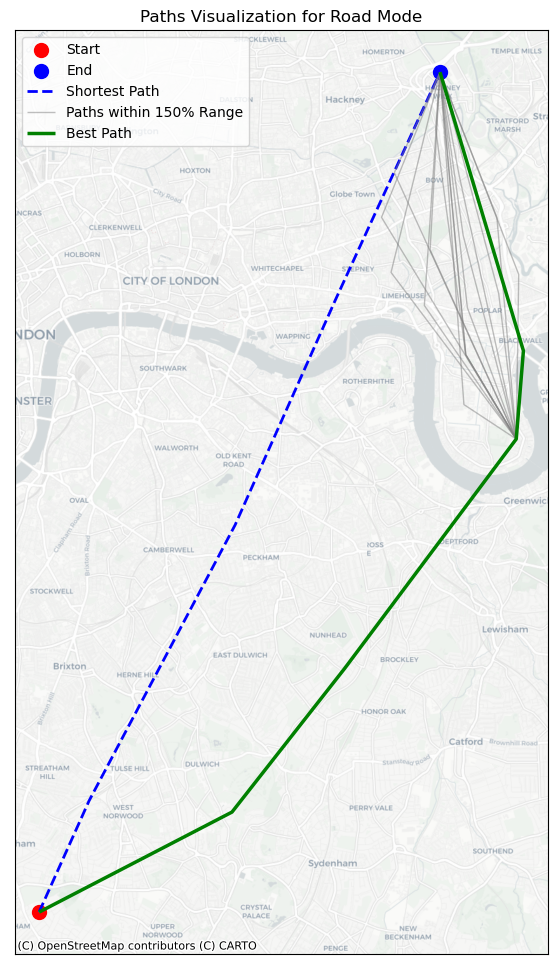

Processing modes:  33%|███▎      | 1/3 [00:32<01:05, 32.55s/it]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\1477417000.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffBus']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\1477417000.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMBus']



Processing mode 1...
Number of paths within 150% range for mode 1: 16

Original Dijkstra (Shortest Path) for mode 1:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   15.344956    2534.10711       15.808513
1   622  51.436340 -0.112083   15.344956    2534.10711       15.808513
2   794  51.478405 -0.076336   15.344956    2534.10711       15.808513
3   853  51.512730 -0.051766   15.344956    2534.10711       15.808513
4   347  51.547432 -0.026151   15.344956    2534.10711       15.808513

High Impact & Low Cost Path for mode 1:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   18.010912   4166.176057       18.385946
1   808  51.434600 -0.077094   18.010912   4166.176057       18.385946
2   804  51.456524 -0.049503   18.010912   4166.176057       18.385946
3   860  51.491520 -0.007478   18.010912   4166.176057       18.385946
4   854  51.511883 -0.029984   18.010912   4166.176057      

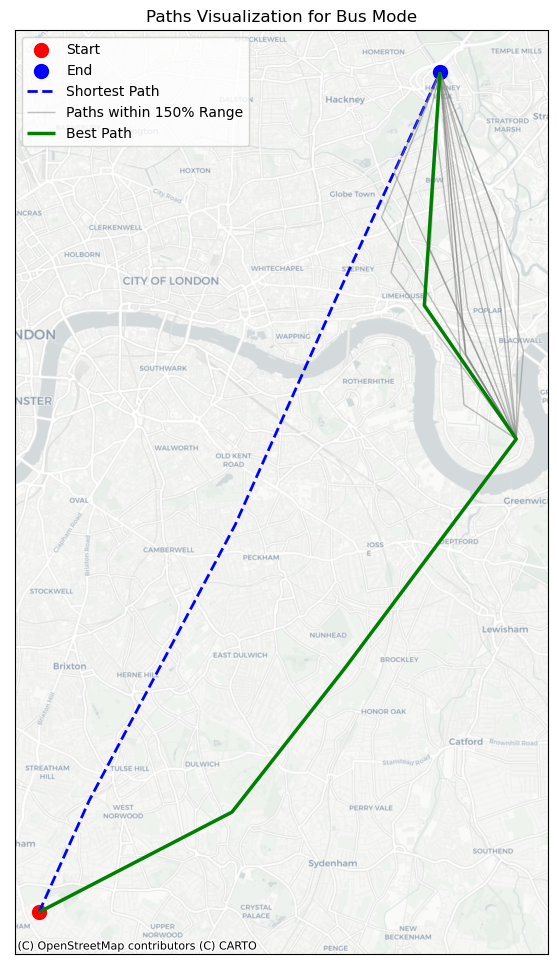

Processing modes:  67%|██████▋   | 2/3 [01:04<00:32, 32.01s/it]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\1477417000.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRail']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\1477417000.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRail']



Processing mode 2...


Processing modes:  67%|██████▋   | 2/3 [01:29<00:44, 44.88s/it]

Number of paths within 150% range for mode 2: 0

Original Dijkstra (Shortest Path) for mode 2:
   node        lat       lon  total_cost  total_impact  total_distance
0   629  51.419320 -0.124340   16.315403   86662.74972       15.969643
1   619  51.445114 -0.112706   16.315403   86662.74972       15.969643
2   604  51.470345 -0.102730   16.315403   86662.74972       15.969643
3   858  51.506744 -0.063764   16.315403   86662.74972       15.969643
4   857  51.508404 -0.062099   16.315403   86662.74972       15.969643
5   347  51.547432 -0.026151   16.315403   86662.74972       15.969643


TypeError: 'NoneType' object is not iterable

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import contextily as ctx
import heapq
from geopy.distance import geodesic
from tqdm import tqdm

# Read files
nodes_file = r'C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\EWS_ZoneCodes_xml.csv'
edges_file = r'C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\OiDj_merged.csv'

nodes_df = pd.read_csv(nodes_file)
edges_df = pd.read_csv(edges_file)

# Create a dictionary of nodes
nodes = {int(row['zonei']): (row['lat'], row['lon']) for idx, row in nodes_df.iterrows()}

# Remove missing values
edges_df = edges_df.dropna(subset=['lat_netj', 'lon_netj'])

# Calculate impact and cost
def calculate_impact_cost(edges_df, mode):
    if mode == 0:
        edges_df['impact'] = edges_df['CkDiffRoad']
        edges_df['cost'] = edges_df['scenarioLinkKMRoad']
    elif mode == 1:
        edges_df['impact'] = edges_df['CkDiffBus']
        edges_df['cost'] = edges_df['scenarioLinkKMBus']
    elif mode == 2:
        edges_df['impact'] = edges_df['CkDiffRail']
        edges_df['cost'] = edges_df['scenarioLinkKMRail']
    return edges_df

# Dijkstra algorithm to calculate the shortest path
def dijkstra_shortest_path(edges_df, start, end):
    pq = [(0, start, [])]  # (distance, node, path)
    visited = set()
    best_distance = {start: 0}

    while pq:
        distance, node, path = heapq.heappop(pq)
        
        if node in visited:
            continue
        visited.add(node)
        
        path = path + [node]
        
        if node == end:
            return (distance, path)
        
        for idx, row in edges_df[edges_df['net_i'] == node].iterrows():
            neighbor = int(row['net_j'])
            start_coords = nodes[node]
            end_coords = (row['lat_netj'], row['lon_netj'])
            edge_distance = geodesic(start_coords, end_coords).kilometers
            new_distance = distance + edge_distance
            
            if neighbor not in best_distance or new_distance < best_distance[neighbor]:
                best_distance[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor, path))

    return None  # No path found

# Bidirectional DFS to find all paths within max distance
def bidirectional_dfs(edges_df, start, end, max_distance, max_revisits=2):
    def get_neighbors(node):
        return [(int(row['net_j']), row['lat_netj'], row['lon_netj']) for idx, row in edges_df[edges_df['net_i'] == node].iterrows()]

    forward_stack = [(start, [start], 0)]  # (current_node, path, current_distance)
    backward_stack = [(end, [end], 0)]
    forward_visited = {start: (0, [start])}
    backward_visited = {end: (0, [end])}
    all_paths = []

    def extend_search(stack, visited, other_visited, is_forward):
        node, path, distance = stack.pop()

        for neighbor, lat, lon in get_neighbors(node):
            new_distance = distance + geodesic(nodes[node], (lat, lon)).kilometers
            new_path = path + [neighbor]

            if new_distance > max_distance or (neighbor in path and path.count(neighbor) > max_revisits):
                continue

            if neighbor in visited:
                continue

            if neighbor in other_visited:
                other_distance, other_path = other_visited[neighbor]
                combined_distance = new_distance + other_distance
                if combined_distance <= max_distance:
                    if is_forward:
                        all_paths.append((combined_distance, new_path + other_path[::-1][1:]))
                    else:
                        all_paths.append((combined_distance, other_path + new_path[::-1][1:]))

            visited[neighbor] = (new_distance, new_path)
            stack.append((neighbor, new_path, new_distance))

    while forward_stack and backward_stack:
        if forward_stack:
            extend_search(forward_stack, forward_visited, backward_visited, True)
        if backward_stack:
            extend_search(backward_stack, backward_visited, forward_visited, False)

    return all_paths

# Calculate total impact and cost for a path
def calculate_path_impact_cost(edges_df, path):
    total_impact = 0
    total_cost = 0
    for i in range(len(path) - 1):
        edge = edges_df[(edges_df['net_i'] == path[i]) & (edges_df['net_j'] == path[i + 1])]
        if not edge.empty:
            total_impact += edge['impact'].values[0]
            total_cost += edge['cost'].values[0]
    return total_impact, total_cost

# Find the path with the highest impact/cost ratio
def find_high_impact_low_cost_path(edges_df, paths):
    best_path = None
    best_ratio = float('-inf')
    best_impact = 0
    best_cost = 0
    best_distance = 0

    for distance, path in paths:
        total_impact, total_cost = calculate_path_impact_cost(edges_df, path)
        if total_cost > 0:
            ratio = total_impact / total_cost
            if ratio > best_ratio:
                best_ratio = ratio
                best_impact = total_impact
                best_cost = total_cost
                best_distance = distance
                best_path = path

    return best_cost, best_impact, best_distance, best_path

# Create GeoDataFrame
def create_geodataframe(paths, nodes):
    geo_data = []
    for path in paths:
        line = [Point(nodes[node][1], nodes[node][0]) for node in path]
        geo_data.append(LineString(line))
    return gpd.GeoDataFrame(geometry=geo_data, crs="EPSG:4326")  # Set coordinate system to WGS84

def plot_paths(mode, shortest_paths, all_paths, best_path, start_point, end_point):
    # Create GeoDataFrame
    shortest_path_gdf = create_geodataframe(shortest_paths, nodes)
    all_paths_gdf = create_geodataframe(all_paths, nodes)
    best_path_gdf = create_geodataframe([best_path], nodes)

    # Create GeoDataFrame for start and end points
    start_gdf = gpd.GeoDataFrame(geometry=[start_point], crs="EPSG:4326")
    end_gdf = gpd.GeoDataFrame(geometry=[end_point], crs="EPSG:4326")

    # Convert coordinate system to Web Mercator
    shortest_path_gdf = shortest_path_gdf.to_crs(epsg=3857)
    all_paths_gdf = all_paths_gdf.to_crs(epsg=3857)
    best_path_gdf = best_path_gdf.to_crs(epsg=3857)
    start_gdf = start_gdf.to_crs(epsg=3857)
    end_gdf = end_gdf.to_crs(epsg=3857)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 12))  # Set the figure size to 12x12 inches
    start_gdf.plot(ax=ax, color='red', markersize=100, label='Start')
    end_gdf.plot(ax=ax, color='blue', markersize=100, label='End')
    shortest_path_gdf.plot(ax=ax, color='blue', linewidth=2, linestyle='--', label='Shortest Path')
    all_paths_gdf.plot(ax=ax, color='gray', linewidth=1, alpha=0.5, label='Paths within 150% Range')
    best_path_gdf.plot(ax=ax, color='green', linewidth=2.5,label='Best Path')

    # Add base map
    ctx.add_basemap(ax, crs=start_gdf.crs, source=ctx.providers.CartoDB.Positron)  # Use a cleaner basemap

    # Remove coordinate axis labels and title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Move the legend to the upper left corner
    ax.legend(loc='upper left')

    mode_names = {0: "Road Mode", 1: "Bus Mode", 2: "Rail Mode"}
    plt.title(f'Paths Visualization for {mode_names[mode]}')
    plt.show()

# Main processing logic
start_node = 629
end_node = 347

for mode in tqdm([0, 1, 2], desc="Processing modes"):
    print(f"\nProcessing mode {mode}...")
    edges_mode = edges_df[edges_df['net_mode'] == mode]
    edges_mode = calculate_impact_cost(edges_mode, mode)
    
    result_shortest = dijkstra_shortest_path(edges_mode, start_node, end_node)
    if result_shortest:
        shortest_distance, shortest_path = result_shortest
        max_distance = shortest_distance * 1.2
        
        all_paths = bidirectional_dfs(edges_mode, start_node, end_node, max_distance)
        print(f"Number of paths within 150% range for mode {mode}: {len(all_paths)}")
        
        best_path = find_high_impact_low_cost_path(edges_mode, all_paths)
        
        if best_path:
            total_cost, total_impact, best_distance, path = best_path
            shortest_paths = [shortest_path]
            all_paths_dict = [p for _, p in all_paths]
            best_path = path
            
            # Calculate impact and cost for the shortest path
            shortest_impact, shortest_cost = calculate_path_impact_cost(edges_mode, shortest_path)
            print(f"\nOriginal Dijkstra (Shortest Path) for mode {mode}:")
            print(pd.DataFrame([{'node': node, 'lat': nodes[node][0], 'lon': nodes[node][1]} for node in shortest_path], 
                               columns=['node', 'lat', 'lon']).assign(total_cost=shortest_cost, total_impact=shortest_impact, total_distance=shortest_distance))
            
            path_info = [{'node': node, 'lat': nodes[node][0], 'lon': nodes[node][1]} for node in path]
            path_df = pd.DataFrame(path_info)
            path_df['total_cost'] = total_cost
            path_df['total_impact'] = total_impact
            path_df['total_distance'] = best_distance
            print(f"\nHigh Impact & Low Cost Path for mode {mode}:")
            print(path_df)
            
            # Plot paths
            start_point = Point(nodes[start_node][1], nodes[start_node][0])  # Ensure correct coordinate order
            end_point = Point(nodes[end_node][1], nodes[end_node][0])  # Ensure correct coordinate order
            plot_paths(mode, shortest_paths, all_paths_dict, best_path, start_point, end_point)
        else:
            print(f"No high impact & low cost path found for mode {mode}")
    else:
        print(f"No path found for mode {mode} using original Dijkstra (Shortest Path)")


Processing modes:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\3999115081.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRoad']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\3999115081.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRoad']



Processing mode 0...
Number of paths within 150% range for mode 0: 24

Original Dijkstra (Shortest Path) for mode 0:
   node        lat       lon  total_cost  total_impact  total_distance
0  1306  53.474330 -2.281889    9.026162    360.518446        9.499051
1  1294  53.502170 -2.258249    9.026162    360.518446        9.499051
2  1012  53.536163 -2.222687    9.026162    360.518446        9.499051
3  1117  53.548020 -2.209926    9.026162    360.518446        9.499051

High Impact & Low Cost Path for mode 0:
   node        lat       lon  total_cost  total_impact  total_distance
0  1306  53.474330 -2.281889    10.03208    930.776779       12.145882
1  1015  53.531433 -2.247813    10.03208    930.776779       12.145882
2  1118  53.538670 -2.191709    10.03208    930.776779       12.145882
3  1117  53.548020 -2.209926    10.03208    930.776779       12.145882


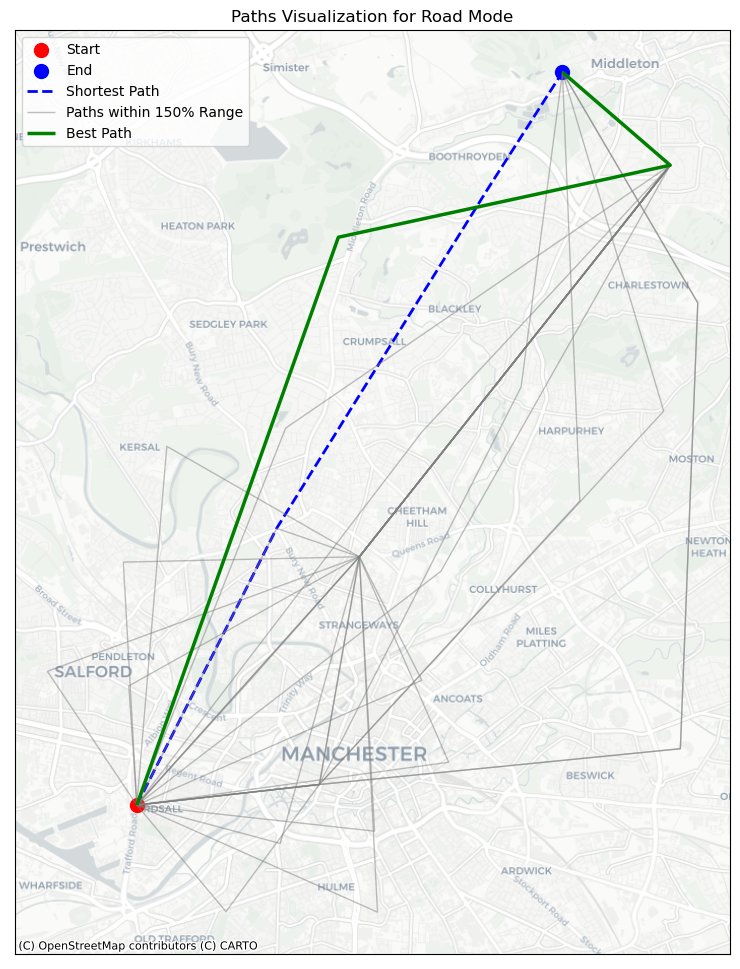

Processing modes:  33%|███▎      | 1/3 [00:04<00:08,  4.07s/it]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\3999115081.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffBus']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\3999115081.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMBus']



Processing mode 1...
Number of paths within 150% range for mode 1: 25

Original Dijkstra (Shortest Path) for mode 1:
   node        lat       lon  total_cost  total_impact  total_distance
0  1306  53.474330 -2.281889    9.709098    995.684446        9.499051
1  1294  53.502170 -2.258249    9.709098    995.684446        9.499051
2  1012  53.536163 -2.222687    9.709098    995.684446        9.499051
3  1117  53.548020 -2.209926    9.709098    995.684446        9.499051

High Impact & Low Cost Path for mode 1:
   node        lat       lon  total_cost  total_impact  total_distance
0  1306  53.474330 -2.281889   14.095782    3497.67337        13.10782
1  1381  53.463604 -2.266815   14.095782    3497.67337        13.10782
2  6774  53.476400 -2.251026   14.095782    3497.67337        13.10782
3  6772  53.499310 -2.244263   14.095782    3497.67337        13.10782
4  1118  53.538670 -2.191709   14.095782    3497.67337        13.10782
5  1117  53.548020 -2.209926   14.095782    3497.67337      

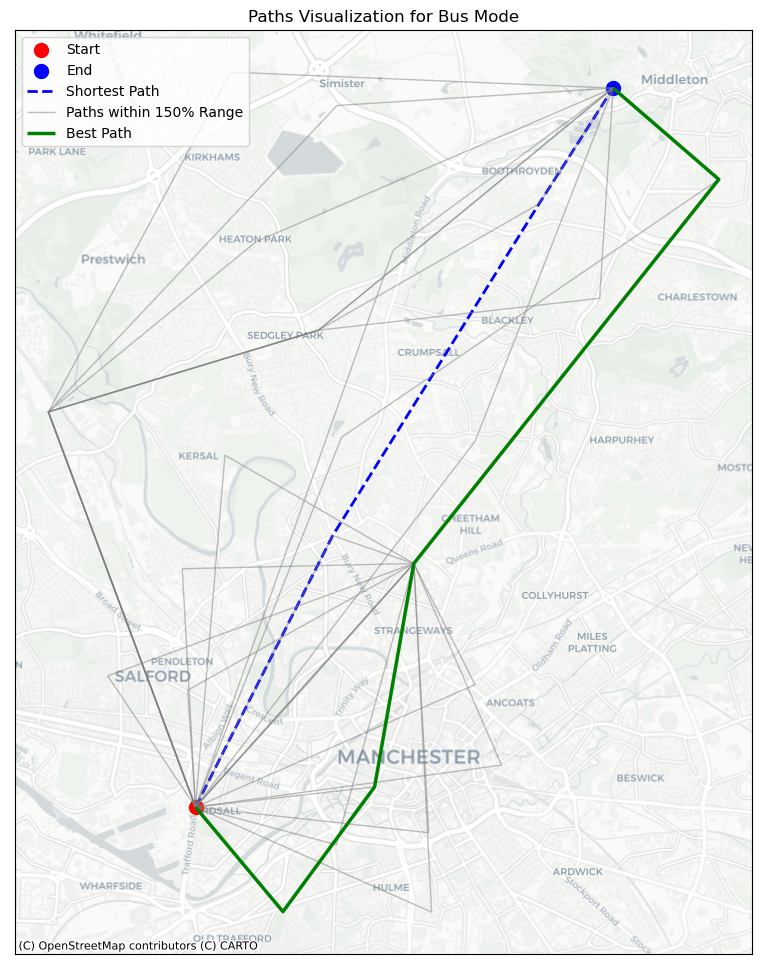

Processing modes:  67%|██████▋   | 2/3 [00:08<00:04,  4.25s/it]C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\3999115081.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['impact'] = edges_df['CkDiffRail']
C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_24160\3999115081.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['cost'] = edges_df['scenarioLinkKMRail']



Processing mode 2...
Number of paths within 150% range for mode 2: 12

Original Dijkstra (Shortest Path) for mode 2:
   node        lat       lon  total_cost  total_impact  total_distance
0  1306  53.474330 -2.281889    9.495193   8518.021039        9.499051
1  1294  53.502170 -2.258249    9.495193   8518.021039        9.499051
2  1012  53.536163 -2.222687    9.495193   8518.021039        9.499051
3  1117  53.548020 -2.209926    9.495193   8518.021039        9.499051

High Impact & Low Cost Path for mode 2:
   node        lat       lon  total_cost  total_impact  total_distance
0  1306  53.474330 -2.281889   14.233689  14432.014499        14.07621
1  6774  53.476400 -2.251026   14.233689  14432.014499        14.07621
2  1020  53.504925 -2.206990   14.233689  14432.014499        14.07621
3  1118  53.538670 -2.191709   14.233689  14432.014499        14.07621
4  1116  53.550915 -2.177705   14.233689  14432.014499        14.07621
5  1117  53.548020 -2.209926   14.233689  14432.014499      

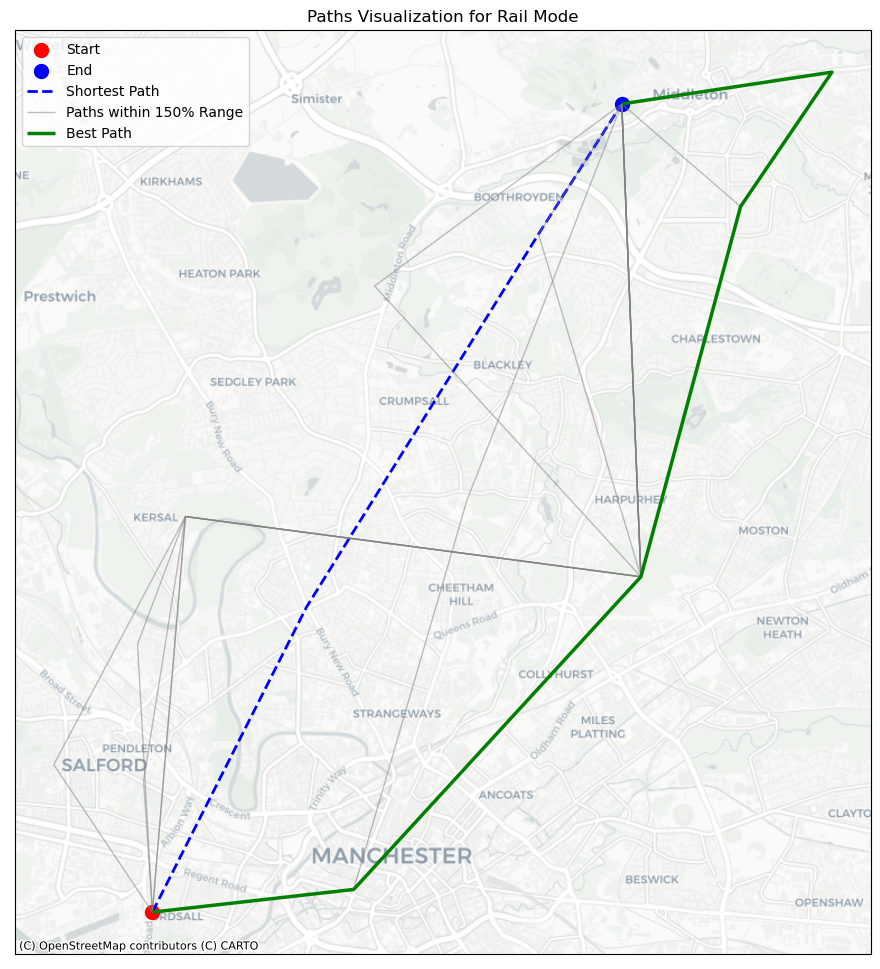

Processing modes: 100%|██████████| 3/3 [00:11<00:00,  3.71s/it]


In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import contextily as ctx
import heapq
from geopy.distance import geodesic
from tqdm import tqdm

# Read files
nodes_file = r'C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\EWS_ZoneCodes_xml.csv'
edges_file = r'C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\OiDj_merged.csv'

nodes_df = pd.read_csv(nodes_file)
edges_df = pd.read_csv(edges_file)

# Create a dictionary of nodes
nodes = {int(row['zonei']): (row['lat'], row['lon']) for idx, row in nodes_df.iterrows()}

# Remove missing values
edges_df = edges_df.dropna(subset=['lat_netj', 'lon_netj'])

# Calculate impact and cost
def calculate_impact_cost(edges_df, mode):
    if mode == 0:
        edges_df['impact'] = edges_df['CkDiffRoad']
        edges_df['cost'] = edges_df['scenarioLinkKMRoad']
    elif mode == 1:
        edges_df['impact'] = edges_df['CkDiffBus']
        edges_df['cost'] = edges_df['scenarioLinkKMBus']
    elif mode == 2:
        edges_df['impact'] = edges_df['CkDiffRail']
        edges_df['cost'] = edges_df['scenarioLinkKMRail']
    return edges_df

# Dijkstra algorithm to calculate the shortest path
def dijkstra_shortest_path(edges_df, start, end):
    pq = [(0, start, [])]  # (distance, node, path)
    visited = set()
    best_distance = {start: 0}

    while pq:
        distance, node, path = heapq.heappop(pq)
        
        if node in visited:
            continue
        visited.add(node)
        
        path = path + [node]
        
        if node == end:
            return (distance, path)
        
        for idx, row in edges_df[edges_df['net_i'] == node].iterrows():
            neighbor = int(row['net_j'])
            start_coords = nodes[node]
            end_coords = (row['lat_netj'], row['lon_netj'])
            edge_distance = geodesic(start_coords, end_coords).kilometers
            new_distance = distance + edge_distance
            
            if neighbor not in best_distance or new_distance < best_distance[neighbor]:
                best_distance[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor, path))

    return None  # No path found

# Bidirectional DFS to find all paths within max distance
def bidirectional_dfs(edges_df, start, end, max_distance, max_revisits=2):
    def get_neighbors(node):
        return [(int(row['net_j']), row['lat_netj'], row['lon_netj']) for idx, row in edges_df[edges_df['net_i'] == node].iterrows()]

    forward_stack = [(start, [start], 0)]  # (current_node, path, current_distance)
    backward_stack = [(end, [end], 0)]
    forward_visited = {start: (0, [start])}
    backward_visited = {end: (0, [end])}
    all_paths = []

    def extend_search(stack, visited, other_visited, is_forward):
        node, path, distance = stack.pop()

        for neighbor, lat, lon in get_neighbors(node):
            new_distance = distance + geodesic(nodes[node], (lat, lon)).kilometers
            new_path = path + [neighbor]

            if new_distance > max_distance or (neighbor in path and path.count(neighbor) > max_revisits):
                continue

            if neighbor in visited:
                continue

            if neighbor in other_visited:
                other_distance, other_path = other_visited[neighbor]
                combined_distance = new_distance + other_distance
                if combined_distance <= max_distance:
                    if is_forward:
                        all_paths.append((combined_distance, new_path + other_path[::-1][1:]))
                    else:
                        all_paths.append((combined_distance, other_path + new_path[::-1][1:]))

            visited[neighbor] = (new_distance, new_path)
            stack.append((neighbor, new_path, new_distance))

    while forward_stack and backward_stack:
        if forward_stack:
            extend_search(forward_stack, forward_visited, backward_visited, True)
        if backward_stack:
            extend_search(backward_stack, backward_visited, forward_visited, False)

    return all_paths

# Calculate total impact and cost for a path
def calculate_path_impact_cost(edges_df, path):
    total_impact = 0
    total_cost = 0
    for i in range(len(path) - 1):
        edge = edges_df[(edges_df['net_i'] == path[i]) & (edges_df['net_j'] == path[i + 1])]
        if not edge.empty:
            total_impact += edge['impact'].values[0]
            total_cost += edge['cost'].values[0]
    return total_impact, total_cost

# Find the path with the highest impact/cost ratio
def find_high_impact_low_cost_path(edges_df, paths):
    best_path = None
    best_ratio = float('-inf')
    best_impact = 0
    best_cost = 0
    best_distance = 0

    for distance, path in paths:
        total_impact, total_cost = calculate_path_impact_cost(edges_df, path)
        if total_cost > 0:
            ratio = total_impact / total_cost
            if ratio > best_ratio:
                best_ratio = ratio
                best_impact = total_impact
                best_cost = total_cost
                best_distance = distance
                best_path = path

    return best_cost, best_impact, best_distance, best_path

# Create GeoDataFrame
def create_geodataframe(paths, nodes):
    geo_data = []
    for path in paths:
        line = [Point(nodes[node][1], nodes[node][0]) for node in path]
        geo_data.append(LineString(line))
    return gpd.GeoDataFrame(geometry=geo_data, crs="EPSG:4326")  # Set coordinate system to WGS84

def plot_paths(mode, shortest_paths, all_paths, best_path, start_point, end_point):
    # Create GeoDataFrame
    shortest_path_gdf = create_geodataframe(shortest_paths, nodes)
    all_paths_gdf = create_geodataframe(all_paths, nodes)
    best_path_gdf = create_geodataframe([best_path], nodes)

    # Create GeoDataFrame for start and end points
    start_gdf = gpd.GeoDataFrame(geometry=[start_point], crs="EPSG:4326")
    end_gdf = gpd.GeoDataFrame(geometry=[end_point], crs="EPSG:4326")

    # Convert coordinate system to Web Mercator
    shortest_path_gdf = shortest_path_gdf.to_crs(epsg=3857)
    all_paths_gdf = all_paths_gdf.to_crs(epsg=3857)
    best_path_gdf = best_path_gdf.to_crs(epsg=3857)
    start_gdf = start_gdf.to_crs(epsg=3857)
    end_gdf = end_gdf.to_crs(epsg=3857)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 12))  # Set the figure size to 12x12 inches
    start_gdf.plot(ax=ax, color='red', markersize=100, label='Start')
    end_gdf.plot(ax=ax, color='blue', markersize=100, label='End')
    shortest_path_gdf.plot(ax=ax, color='blue', linewidth=2, linestyle='--', label='Shortest Path')
    all_paths_gdf.plot(ax=ax, color='gray', linewidth=1, alpha=0.5, label='Paths within 150% Range')
    best_path_gdf.plot(ax=ax, color='green', linewidth=2.5,label='Best Path')

    # Add base map
    ctx.add_basemap(ax, crs=start_gdf.crs, source=ctx.providers.CartoDB.Positron)  # Use a cleaner basemap

    # Remove coordinate axis labels and title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Move the legend to the upper left corner
    ax.legend(loc='upper left')

    mode_names = {0: "Road Mode", 1: "Bus Mode", 2: "Rail Mode"}
    plt.title(f'Paths Visualization for {mode_names[mode]}')
    plt.show()

# Main processing logic
start_node = 1306
end_node = 1117

for mode in tqdm([0, 1, 2], desc="Processing modes"):
    print(f"\nProcessing mode {mode}...")
    edges_mode = edges_df[edges_df['net_mode'] == mode]
    edges_mode = calculate_impact_cost(edges_mode, mode)
    
    result_shortest = dijkstra_shortest_path(edges_mode, start_node, end_node)
    if result_shortest:
        shortest_distance, shortest_path = result_shortest
        max_distance = shortest_distance * 1.5
        
        all_paths = bidirectional_dfs(edges_mode, start_node, end_node, max_distance)
        print(f"Number of paths within 150% range for mode {mode}: {len(all_paths)}")
        
        best_path = find_high_impact_low_cost_path(edges_mode, all_paths)
        
        if best_path:
            total_cost, total_impact, best_distance, path = best_path
            shortest_paths = [shortest_path]
            all_paths_dict = [p for _, p in all_paths]
            best_path = path
            
            # Calculate impact and cost for the shortest path
            shortest_impact, shortest_cost = calculate_path_impact_cost(edges_mode, shortest_path)
            print(f"\nOriginal Dijkstra (Shortest Path) for mode {mode}:")
            print(pd.DataFrame([{'node': node, 'lat': nodes[node][0], 'lon': nodes[node][1]} for node in shortest_path], 
                               columns=['node', 'lat', 'lon']).assign(total_cost=shortest_cost, total_impact=shortest_impact, total_distance=shortest_distance))
            
            path_info = [{'node': node, 'lat': nodes[node][0], 'lon': nodes[node][1]} for node in path]
            path_df = pd.DataFrame(path_info)
            path_df['total_cost'] = total_cost
            path_df['total_impact'] = total_impact
            path_df['total_distance'] = best_distance
            print(f"\nHigh Impact & Low Cost Path for mode {mode}:")
            print(path_df)
            
            # Plot paths
            start_point = Point(nodes[start_node][1], nodes[start_node][0])  # Ensure correct coordinate order
            end_point = Point(nodes[end_node][1], nodes[end_node][0])  # Ensure correct coordinate order
            plot_paths(mode, shortest_paths, all_paths_dict, best_path, start_point, end_point)
        else:
            print(f"No high impact & low cost path found for mode {mode}")
    else:
        print(f"No path found for mode {mode} using original Dijkstra (Shortest Path)")
